# 수집한 데이터를 가지고 뭐라도 좀 해보자. 

In [1]:
import pandas as pd

df = pd.read_csv('./resources/csv/bugsChartScrapy_20200616.psv',
                 sep='|',
                 names=['ranking', 'title', 'artist', 'album', 'date'],
                 encoding='utf-8')
df.head()

,ranking,title,artist,album,date
0,1.0,운다,손호영,Yes,2006.09.22
1,2.0,제발,이승기,남자가 여자를 사랑할 때 (Special Album),2006.09.22
2,3.0,마음을 잃다,넬(NELL),Healing Process,2006.09.22
3,4.0,I Love Rock & Roll,코요태,London Koyote,2006.09.22
4,5.0,The Day,브라운 아이드 걸스,To My Lover - 브라운 아이드 걸스 & 씨야 프로젝트 싱글,2006.09.22


In [2]:
df.shape

(501773, 5)

In [3]:
# ranking 이 null인 행의 수
df['ranking'].isna().sum()

1769

In [4]:
# ranking이 null인 행은 자료가 이상하다. 
# bugsMusic에 들어가보니 공통적으로 스트리밍 제한된 title이 존재.
# 본인이 생각한 tag구조와 다른가보다.
df.loc[df['ranking'].isna()].head()

,ranking,title,artist,album,date
488,NaN,2009.11.20,NaN,NaN,NaN
497,NaN,2007.04.20,NaN,NaN,NaN
558,NaN,2007.04.20,NaN,NaN,NaN
585,NaN,2007.04.20,NaN,NaN,NaN
859,NaN,2009.01.09,NaN,NaN,NaN


In [5]:
# ranking이 null이 아닌 행만 취한다.
df_notnull = df[~df['ranking'].isna()]
df_notnull['ranking'].isna().sum()

0

In [6]:
# ranking 칼럼값이 없으면 곤란하니 삭제는 했는데
# 생각해보니 나머지 값들도 마찬가지다
# 그냥 null을 하나라도 포함하는 행들은 전부 삭제를해주자.
df_notnull.dropna(inplace=True)

/home/jhleeeme/.pyenv/versions/3.5.2/envs/jupyter-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [7]:
df_notnull.sort_values(['date', 'ranking'], ascending=[False, True], inplace=True)
df_notnull.head()

/home/jhleeeme/.pyenv/versions/3.5.2/envs/jupyter-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,ranking,title,artist,album,date
478941,1.0,Downtown Baby,블루(BLOO),Downtown Baby,2020.06.14
478942,2.0,MORE & MORE,TWICE (트와이스),MORE & MORE,2020.06.14
478943,3.0,에잇(Prod.&Feat. SUGA of BTS),아이유(IU),에잇,2020.06.14
478944,4.0,사랑하게 될 줄 알았어,전미도,슬기로운 의사생활 OST Part 11,2020.06.14
478945,5.0,작사가,헤이즈(Heize),Lyricist,2020.06.14


In [8]:
df_notnull = df_notnull.astype({'date': 'datetime64', 'ranking': 'int64'})
df_notnull.dtypes

ranking             int64
title              object
artist             object
album              object
date       datetime64[ns]
dtype: object

In [9]:
df_notnull.shape

(498235, 5)

In [10]:
# 1/ranking 으로 점수를 매겨보자
# e.g. 1등: 1점, 2등: 0.5점, ..., 10등: 0.1점
df_notnull['score'] = 1/df_notnull['ranking']
df_notnull.head()

,ranking,title,artist,album,date,score
478941,1,Downtown Baby,블루(BLOO),Downtown Baby,2020-06-14,1.000000
478942,2,MORE & MORE,TWICE (트와이스),MORE & MORE,2020-06-14,0.500000
478943,3,에잇(Prod.&Feat. SUGA of BTS),아이유(IU),에잇,2020-06-14,0.333333
478944,4,사랑하게 될 줄 알았어,전미도,슬기로운 의사생활 OST Part 11,2020-06-14,0.250000
478945,5,작사가,헤이즈(Heize),Lyricist,2020-06-14,0.200000


### 일단 여기까지 전처리한 데이터를 psv파일로 저장

In [11]:
df_notnull.to_csv('./resources/csv/bugsChart_score.psv',
                  sep='|',
                  index=False,
                  encoding='utf8')

---
## MySQL에 데이터를 넣고, 살펴보자.

In [12]:
import pymysql


host = 'localhost'
username = 'JHLeeeMe'
password = '********'
db_name = 'bugsMusic_db'

db = pymysql.connect(
        host = host,
        port = 3306,
        user = username,
        passwd= password,
        db = db_name,
        charset = 'utf8'
)

In [13]:
sql_drop_table = """
    DROP TABLE IF EXISTS bugsMusic_db.bugsChart_tb
"""

sql_create_table = """
    CREATE TABLE bugsMusic_db.bugsChart_tb (
        ranking int             not null,
        title   varchar(100)    not null,
        artist  varchar(100)    not null,
        album   varchar(100)    not null,
        date_   date            not null,
        score   float           not null
    ) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
"""

# sql_load_data = """
#     load data infile './resources/csv/bugsChart_score.psv'
#     into table bugsMusic_db.bugsChart_tb
#     fields terminated by '|'
#     lines terminated by '\n'
#     ignore 1 lines
# """

In [14]:
cursor = db.cursor()

cursor.execute(sql_drop_table)
cursor.execute(sql_create_table)
# cursor.execute(sql_load_data)

db.commit()

---

### 일단 그래프에서 한글폰트 깨짐 문제 해결을 위한 코드

In [15]:
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
%matplotlib inline

# 한글 사용시 마이너스 폰트가 깨지는 문제가 발생할 수 있으므로 설정변경
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~~~~~~')

## 1. 점수가 가장 높은 가수는?

In [16]:
sql_artist_score = """
    select artist, sum(score)
      from bugsChart_tb
     group by artist
     order by sum(score) desc
     limit 10;
"""

In [17]:
artist_score_df = pd.read_sql(sql_artist_score, db)
artist_score_df.set_index('artist', inplace=True)
artist_score_df

,sum(score)
artist,
아이유(IU),584.004760
BIGBANG,437.742153
다비치,371.404638
볼빨간사춘기,330.655340
TWICE (트와이스),277.568538
태연 (TAEYEON),264.421062
소녀시대 (GIRLS' GENERATION),237.066701
케이윌,235.490209
백지영,234.864432


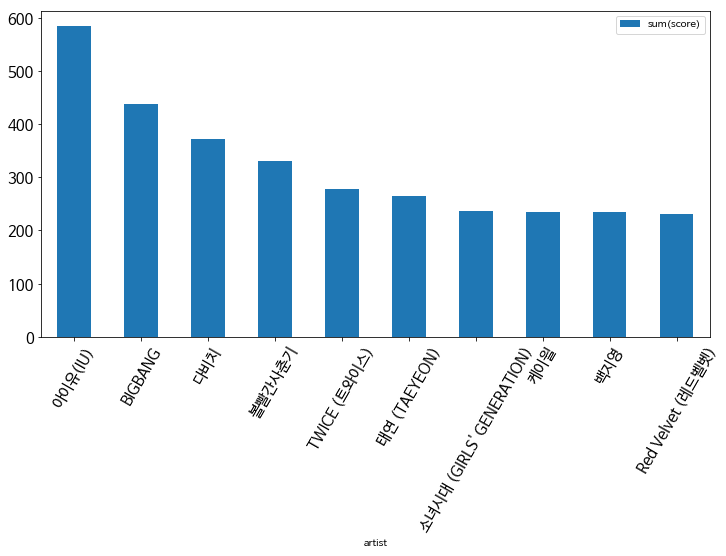

In [18]:
artist_score_df.plot(kind='bar', figsize=(12, 6), fontsize=15, rot=60)

## 2. 타이틀 점수 TOP10

In [19]:
# Title 점수 TOP10
sql_title_score = """
    select artist, title, sum(score)
      from bugsChart_tb
     group by artist, title
     order by sum(score) desc
     limit 10
"""

In [20]:
title_score_df = pd.read_sql(sql_title_score, db)
title_score_df.set_index(['artist', 'title'], inplace=True)
title_score_df

sum(score)
artist       title                                            
쥬얼리(Jewelry) One More Time                           65.087647
MC몽          서커스 (feat. 임유경 - 달래 음악단, $howgun)       56.026355
BIGBANG      하루하루                                    45.646840
백지영          총맞은 것처럼                                 45.326374
장범준          흔들리는 꽃들 속에서 네 샴푸향이 느껴진거야                45.266149
에일리(Ailee)   첫눈처럼 너에게 가겠다                            43.388505
iKON         사랑을 했다 (LOVE SCENARIO)                  43.375965
아이유(IU)      Blueming                                42.402319
             밤편지                                     41.842738
폴킴(Paul Kim) 모든 날, 모든 순간 (Every day, Every Moment)   41.221391

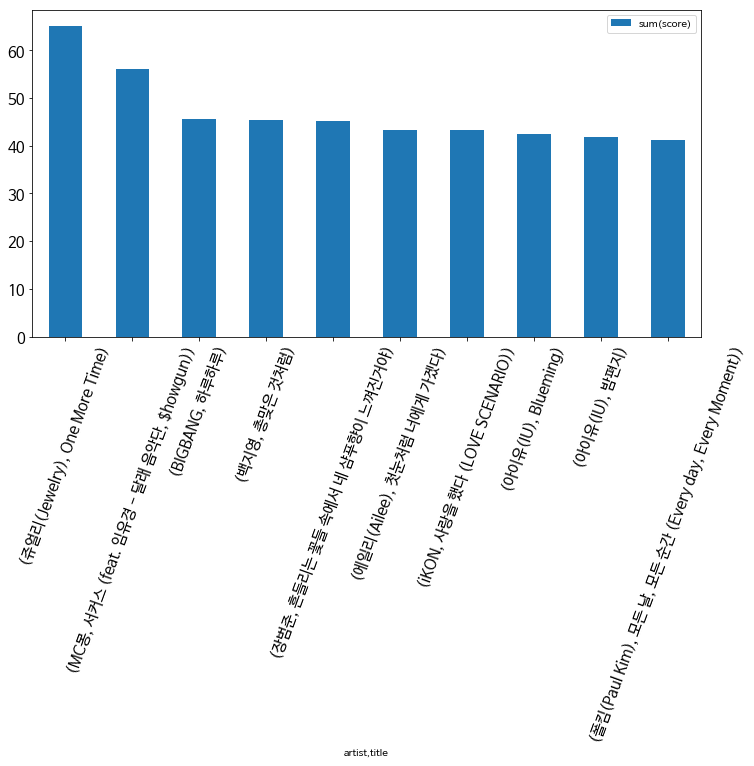

In [21]:
title_score_df.plot(kind='bar', figsize=(12, 6), fontsize=15, rot=70)

## 3. 가장 많이 언급된 타이틀 TOP10

In [22]:
sql_title_count = """
    select artist, title, count(title)
      from bugsChart_tb
     group by artist, title
     order by count(title) desc
     limit 10
"""

In [23]:
title_count_df = pd.read_sql(sql_title_count, db)
title_count_df.set_index(['artist', 'title'], inplace=True)
title_count_df

count(title)
artist                   title                                              
아이유(IU)                  밤편지                                            1177
폴킴(Paul Kim)             모든 날, 모든 순간 (Every day, Every Moment)           818
                         비                                               744
에일리(Ailee)               첫눈처럼 너에게 가겠다                                    705
Ed Sheeran(에드 시런)        Shape Of You                                    683
정승환                      너였다면                                            674
버스커 버스커(Busker Busker)   벚꽃 엔딩                                           638
The Chainsmokers(체인스모커스) Closer (feat. Halsey)                           633
폴킴(Paul Kim)             너를 만나                                           595
DEAN(딘)                  D (half moon) (Feat. 개코)                        592

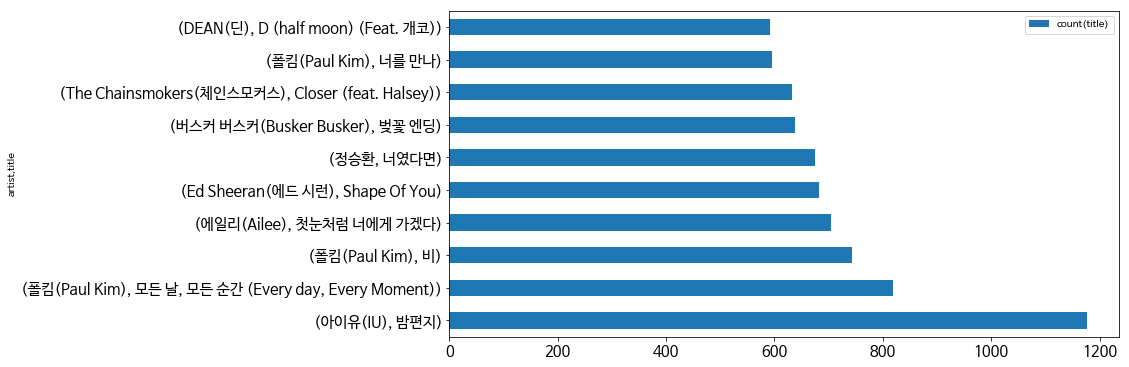

In [24]:
title_count_df.plot(kind='barh', figsize=(12, 6), fontsize=15)

## 4. 앨범 점수 TOP10

In [25]:
sql_album_score = """
    select artist, album, sum(score)
      from bugsChart_tb
     group by artist, album
     order by sum(score) desc
     limit 10;
"""

In [26]:
album_score_df = pd.read_sql(sql_album_score, db)
album_score_df.set_index(['artist', 'album'], inplace=True)
album_score_df

,,sum(score)
artist,album,
아이유(IU),Love poem,80.178207
볼빨간사춘기,Full Album RED PLANET,69.239082
버스커 버스커(Busker Busker),버스커 버스커 1집,68.931575
쥬얼리(Jewelry),Kitchi Island,65.359024
MC몽,Show's Just Begun,62.662819
BLACKPINK,SQUARE UP,61.418836
BIGBANG,Stand Up (2008 빅뱅 3rd Mini Album),57.874649
싸이 (PSY),싸이6甲 Part.1,57.317014
AKMU (악동뮤지션),항해,55.485827


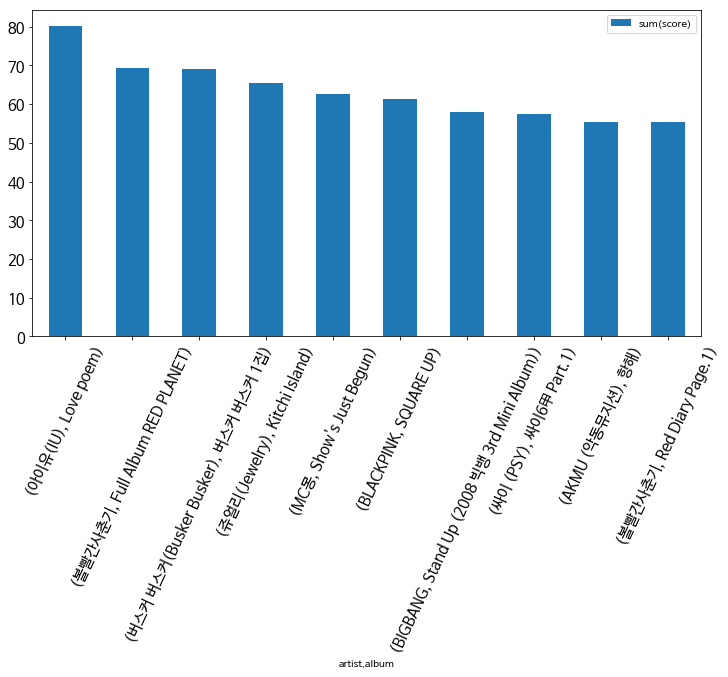

In [27]:
album_score_df.plot(kind='bar', figsize=(12, 6), fontsize=15, rot=65)

In [ ]:
db.close()